In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import TimeSeriesSplit

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission=pd.read_csv('data/sample_submission.csv')

### 결측치 확인 및 처리

In [3]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [4]:
test.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

In [5]:
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1)

### Binary Feature

In [6]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(train['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(train['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(train['work_phone'].value_counts())
print('--------------')

gender :
0    17697
1     8760
Name: gender, dtype: int64
--------------
Having a car or not : 
0    16410
1    10047
Name: car, dtype: int64
--------------
Having house reality or not: 
1    17830
0     8627
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    18672
1     7785
Name: phone, dtype: int64
--------------
Having a email or not: 
0    24042
1     2415
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    20511
1     5946
Name: work_phone, dtype: int64
--------------


### Continuous Feature

<AxesSubplot:>

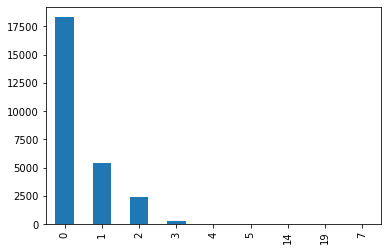

In [7]:
train['child_num'].value_counts(sort=False).plot.bar()

In [8]:
train.loc[train['child_num'] >= 2,'child_num']=2
test.loc[test['child_num']>=2, 'child_num']=2

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


<AxesSubplot:ylabel='Frequency'>

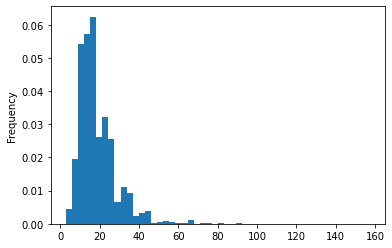

In [9]:
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000 
test['income_total'] = test['income_total']/10000
##############################################################3
print(train['income_total'].value_counts(bins=10,sort=False))
train['income_total'].plot(kind='hist',bins=50,density=True)

In [10]:
print(train['income_type'].unique())
print(train['edu_type'].unique())
print(train['family_type'].unique())
print(train['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [11]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])
########################################################################
train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])
########################################################################
train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])
########################################################################
train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])
########################################################################
train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])

* * *

In [12]:
train['FLAG_MOBIL'].describe()

count    26457.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: FLAG_MOBIL, dtype: float64

In [13]:
test['FLAG_MOBIL'].describe()

count    10000.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: FLAG_MOBIL, dtype: float64

In [14]:
train.drop(['FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['FLAG_MOBIL'], axis=1, inplace=True)

* * *

In [15]:
train['DAYS_BIRTH_month']=np.floor((-train['DAYS_BIRTH'])/30)-((np.floor((-train['DAYS_BIRTH'])/30)/12).astype(int)*12)
train['DAYS_BIRTH_week']=np.floor((-train['DAYS_BIRTH'])/7)-((np.floor((-train['DAYS_BIRTH'])/7)/4).astype(int)*4)

test['DAYS_BIRTH_month']=np.floor((-test['DAYS_BIRTH'])/30)-((np.floor((-test['DAYS_BIRTH'])/30)/12).astype(int)*12)
test['DAYS_BIRTH_week']=np.floor((-test['DAYS_BIRTH'])/7)-((np.floor((-test['DAYS_BIRTH'])/7)/4).astype(int)*4)

In [16]:
train['DAYS_EMPLOYED_month']=np.floor((-train['DAYS_EMPLOYED'])/30)-((np.floor((-train['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
train['DAYS_EMPLOYED_week']=np.floor((-train['DAYS_EMPLOYED'])/7)-((np.floor((-train['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

test['DAYS_EMPLOYED_month']=np.floor((-test['DAYS_EMPLOYED'])/30)-((np.floor((-test['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
test['DAYS_EMPLOYED_week']=np.floor((-test['DAYS_EMPLOYED'])/7)-((np.floor((-test['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

In [17]:
train['before_EMPLOYED']=train['DAYS_BIRTH']-train['DAYS_EMPLOYED']
train['before_EMPLOYED_month']=np.floor((-train['before_EMPLOYED'])/30)-((np.floor((-train['before_EMPLOYED'])/30)/12).astype(int)*12)
train['before_EMPLOYED_week']=np.floor((-train['before_EMPLOYED'])/7)-((np.floor((-train['before_EMPLOYED'])/7)/4).astype(int)*4)

test['before_EMPLOYED']=test['DAYS_BIRTH']-test['DAYS_EMPLOYED']
test['before_EMPLOYED_month']=np.floor((-test['before_EMPLOYED'])/30)-((np.floor((-test['before_EMPLOYED'])/30)/12).astype(int)*12)
test['before_EMPLOYED_week']=np.floor((-test['before_EMPLOYED'])/7)-((np.floor((-test['before_EMPLOYED'])/7)/4).astype(int)*4)

In [18]:
train['DAYS_EMPLOYED'].value_counts()

 365243    4438
-401         57
-1539        47
-200         45
-2087        44
           ... 
-10475        1
-2202         1
-2552         1
-680          1
-4973         1
Name: DAYS_EMPLOYED, Length: 3470, dtype: int64

* * *

In [19]:
train['income_family'] = train['income_total'] / train['family_size']
test['income_family'] = test['income_total'] / test['family_size']

In [20]:
train['DAYS_BIRTH2'] = train['DAYS_BIRTH']**2
test['DAYS_BIRTH2'] = test['DAYS_BIRTH']**2

In [21]:
train['income_age'] = train['income_total'] * train['DAYS_BIRTH']
test['income_age'] = test['income_total'] * test['DAYS_BIRTH']

* * *

In [22]:
train['ID'] = train['child_num'].astype(str) + '_' + train['income_total'].astype(str) + '_' + train['DAYS_BIRTH'].astype(str) + '_' + train['DAYS_EMPLOYED'].astype(str) + '_' + train['work_phone'].astype(str) + '_' + train['phone'].astype(str) + '_' + train['email'].astype(str) + '_' + train['family_size'].astype(str) + '_' + train['gender'].astype(str) + '_' + train['car'].astype(str) + '_' + train['reality'].astype(str) + '_' + train['income_type'].astype(str) + '_' + train['edu_type'].astype(str) + '_' + train['family_type'].astype(str) + '_' + train['house_type'].astype(str)

In [23]:
test['ID'] = test['child_num'].astype(str) + '_' + test['income_total'].astype(str) + '_' + test['DAYS_BIRTH'].astype(str) + '_' + test['DAYS_EMPLOYED'].astype(str) + '_' + test['work_phone'].astype(str) + '_' + test['phone'].astype(str) + '_' + test['email'].astype(str) + '_' + test['family_size'].astype(str) + '_' + test['gender'].astype(str) + '_' + test['car'].astype(str) + '_' + test['reality'].astype(str) + '_' + test['income_type'].astype(str) + '_' + test['edu_type'].astype(str) + '_' + test['family_type'].astype(str) + '_' + test['house_type'].astype(str)

In [24]:
train = train.astype({'ID':'str'})
test = test.astype({'ID':'str'})

* * *

In [25]:
#구간화 함수
def make_bin(df, variable, n):
    
    data = df
    count, bin_dividers = np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data['%s_bin' % variable] = pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]
    print(data['%s_bin' % variable], '\n\n')
    
    return data

In [26]:
train = make_bin(train, 'DAYS_BIRTH', n=10)
test = make_bin(test, 'DAYS_BIRTH', n=10)

0        0
1        1
2        2
3        3
4        3
        ..
26452    1
26453    3
26454    5
26455    5
26456    2
Name: DAYS_BIRTH_bin, Length: 26457, dtype: int64 


0       0
1       1
2       2
3       1
4       3
       ..
9995    1
9996    8
9997    4
9998    3
9999    9
Name: DAYS_BIRTH_bin, Length: 10000, dtype: int64 




* * *

In [27]:
edu_dict = {'Lower secondary':1,
 'Secondary / secondary special':2,
 'Incomplete higher':3,
 'Higher education':4,
 'Academic degree':5}

train['edu_type'].replace(edu_dict,inplace=True)
test['edu_type'].replace(edu_dict,inplace=True)

In [28]:
house_dict = {'With parents':3,
 'Co-op apartment':2,
 'Municipal apartment':1,
 'Rented apartment':4,
 'Office apartment':5,
 'House / apartment':6}

train['house_type'].replace(house_dict,inplace=True)
test['house_type'].replace(house_dict,inplace=True)

* * *

In [29]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)

In [30]:
train['ID'] = oe.fit_transform(train[['ID']])
test['ID'] = oe.transform(test[['ID']])

* * *

In [31]:
train.to_csv('data/train_fe.csv')
test.to_csv('data/test_fe.csv')

In [32]:
import optuna
from optuna.samplers import TPESampler

## Random Forest

In [ ]:
X = pd.read_csv('data/train_fe.csv', encoding='cp949').drop(['credit', 'Unnamed: 0'],axis=1)
y = pd.read_csv('data/train_fe.csv', encoding='cp949').credit
X_test = pd.read_csv('data/test_fe.csv', encoding='cp949').drop(columns=['Unnamed: 0'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
def objective(trial):
    param = {
      "random_state":42,
      "n_estimators":trial.suggest_int("n_estimators", 100, 5000, step=5),
      "max_depth":trial.suggest_int("max_depth", 20, 50, step=1),
      "min_samples_leaf":trial.suggest_int("min_samples_leaf", 30, 200, step=5),
      "max_leaf_nodes":trial.suggest_int("max_leaf_nodes", 30, 200, step=5),
    }

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    rf = RandomForestClassifier(**param)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict_proba(X_test)
    log_score = log_loss(y_test, rf_pred)

    return log_score

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=100), direction="minimize")
study.optimize(objective, n_trials=5)

print("Best score:", study.best_value)
print("Best parameters:", study.best_params)

In [ ]:
tree.predict(X_test)[:, 1:]

In [ ]:
tree = RandomForestClassifier(**study.best_params, random_state= 42)
tree.fit(X_train, y_train)
logloss_score = log_loss(y_test, tree.predict_proba(X_test))
print('log_loss_score {}: '.format('42'), logloss_score)

for i in range(100):
    tree = RandomForestClassifier(**study.best_params, random_state= i)
    tree.fit(X_train, y_train)
    logloss_score = log_loss(y_test, tree.predict_proba(X_test)[:,1])
    print('log_loss_score {}: '.format(i), logloss_score)

In [ ]:
tree.predict_proba(X_test[:, 1])

* * *

## Catboost

In [33]:
X = pd.read_csv('data/train_fe.csv', encoding='cp949').drop(['credit', 'Unnamed: 0'],axis=1)
y = pd.read_csv('data/train_fe.csv', encoding='cp949').credit
X_test = pd.read_csv('data/test_fe.csv', encoding='cp949').drop(columns=['Unnamed: 0'])

In [ ]:
del X_train
del X_test

In [34]:
def objective(trial):
    param = {
      "random_state":42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }

    X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)

    cat_features =[0,1,2,5,6,7,8,15,18]
    cat = CatBoostClassifier(**param)
    cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
    cat_pred = cat.predict_proba(X_valid)
    log_score = log_loss(y_valid, cat_pred)

    return log_score

In [35]:
X = X.astype(str)
y = y.astype(str)

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-11-27 10:37:47,426] A new study created in memory with name: no-name-4d40ba45-dd8c-4e12-bb73-ebc0a73a1019


0:	learn: 1.0829489	test: 1.0829489	test1: 1.0828958	best: 1.0828958 (0)	total: 137ms	remaining: 17m 15s
100:	learn: 0.8825703	test: 0.8825703	test1: 0.8827909	best: 0.8827909 (100)	total: 1s	remaining: 1m 14s


[I 2022-11-27 10:37:49,734] Trial 0 finished with value: 0.882684079492545 and parameters: {'learning_rate': 0.03574712922600244, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'colsample_bylevel': 0.49359671220172163, 'l2_leaf_reg': 1.7519275289243016e-06, 'min_child_samples': 88, 'max_bin': 380, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.882684079492545.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8826840795
bestIteration = 140

Shrink model to first 141 iterations.
0:	learn: 0.9884999	test: 0.9884999	test1: 0.9864963	best: 0.9864963 (0)	total: 47.2ms	remaining: 2m 17s
100:	learn: 0.6962589	test: 0.7058049	test1: 0.7796335	best: 0.7796335 (100)	total: 5.63s	remaining: 2m 36s
200:	learn: 0.6091650	test: 0.6288406	test1: 0.7568397	best: 0.7566890 (199)	total: 11.3s	remaining: 2m 32s
300:	learn: 0.5451029	test: 0.5757740	test1: 0.7495466	best: 0.7493308 (299)	total: 16.9s	remaining: 2m 26s


[I 2022-11-27 10:38:11,386] Trial 1 finished with value: 0.7466578507067593 and parameters: {'learning_rate': 0.2708160864249968, 'bagging_temperature': 21.368329072358772, 'n_estimators': 2911, 'max_depth': 6, 'random_strength': 18, 'colsample_bylevel': 0.5825453457757226, 'l2_leaf_reg': 1.5747445384650815e-05, 'min_child_samples': 46, 'max_bin': 287, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.7466578507067593.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7466578507
bestIteration = 339

Shrink model to first 340 iterations.
0:	learn: 1.0866401	test: 1.0866401	test1: 1.0867509	best: 1.0867509 (0)	total: 26ms	remaining: 2m 12s
100:	learn: 0.8445072	test: 0.8452240	test1: 0.8555701	best: 0.8555701 (100)	total: 26s	remaining: 21m 26s
200:	learn: 0.8168179	test: 0.8199773	test1: 0.8354427	best: 0.8354427 (200)	total: 51.2s	remaining: 20m 49s
300:	learn: 0.7972778	test: 0.8029044	test1: 0.8221144	best: 0.8221144 (300)	total: 1m 14s	remaining: 19m 42s
400:	learn: 0.7748301	test: 0.7854743	test1: 0.8083093	best: 0.8083093 (400)	total: 1m 46s	remaining: 20m 48s
500:	learn: 0.6164730	test: 0.7069950	test1: 0.7675640	best: 0.7675640 (500)	total: 3m 26s	remaining: 31m 34s
600:	learn: 0.3423142	test: 0.5485951	test1: 0.7212572	best: 0.7212572 (600)	total: 7m 3s	remaining: 52m 51s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7192221832
bestIteration = 657

Shri

[I 2022-11-27 10:48:46,369] Trial 2 finished with value: 0.7192221831602612 and parameters: {'learning_rate': 0.027010527749605478, 'bagging_temperature': 0.2920433847181412, 'n_estimators': 5105, 'max_depth': 14, 'random_strength': 20, 'colsample_bylevel': 0.708540663048167, 'l2_leaf_reg': 1.7776512920172654e-05, 'min_child_samples': 9, 'max_bin': 382, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.7192221831602612.


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx,valid_idx))

In [ ]:
random.seed(42)
cat_models={}

cat_features =[0,1,2,5,6,7,8,15,18]

for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = train.drop(['credit'],axis=1).iloc[train_idx].values 
    X_valid = train.drop(['credit'],axis=1).iloc[valid_idx].values
    y_train = train['credit'][train_idx].values
    y_valid = train['credit'][valid_idx].values

    cat = CatBoostClassifier(**study.best_params)
    cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
    cat_models[fold] = cat
    print(f'================================================================================\n\n')

In [ ]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += cat_models[fold].predict_proba(test)/5

In [ ]:
t = pd.Timestamp.now()
fname = f"CB_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
pd.DataFrame(submit).to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")